# Training 3D U-Net model for semantic segmentation

### Install pkgs

In [ ]:
#!pip install git+https://github.com/copick/copick-utils.git matplotlib tqdm 
#!pip install -q "monai-weekly[ignite, nibabel, tensorboard, mlflow]"

### Copick configuration file template

```
{
    "config_type": "cryoet_data_portal",
    "name": "polnet",
    "description": "A Data Portal project.",
    "version": "1.0.0",

    "pickable_objects": [
        {
            "name": "membrane",
            "is_particle": false,
            "label": 1,
            "go_id": "GO:0016020",            
            "color": [150,150, 150, 255],
            "radius": 10
        },
        {
            "name": "adp-mitochondrial",
            "is_particle": true,
            "pdb_id": "6MRD",
            "go_id": "GO:1990220",
            "label": 2,
            "color": [  0, 117, 220, 255],
            "radius": 75,
            "map_threshold": 0.037
        },
        {
            "name": "alkaline-phosphate",
            "is_particle": true,
            "pdb_id": "1ZEF",
            "go_id": "UniProtKB:P05187",
            "label": 3,
            "color": [  0, 117, 220, 255],
            "radius": 75,
            "map_threshold": 0.037
        },
        {
            "name": "nucleosome",
            "is_particle": true,
            "pdb_id": "6UPH",
            "go_id": "GO:0000786",
            "label": 4,
            "color": [  0, 117, 220, 255],
            "radius": 65,
            "map_threshold": 0.037
        },        
        {
            "name": "ribosome",
            "is_particle": true,
            "pdb_id": "7TM3",
            "go_id": "GO:0022626",
            "label": 5,
            "color": [  0, 117, 220, 255],
            "radius": 165,
            "map_threshold": 0.037
        },
        {
            "name": "vault",
            "is_particle": true,
            "pdb_id": "7PKZ",
            "go_id": "UniProtKB:Q62667",
            "label": 6,
            "color": [  0, 117, 220, 255],
            "radius": 165,
            "map_threshold": 0.037
        },
        {
            "name": "virus-like-capsid",
            "is_particle": true,
            "pdb_id": "6NK5",
            "go_id": "GO:0170047",
            "label": 7,
            "color": [  0, 117, 220, 255],
            "radius": 140,
            "map_threshold": 0.037
        }             
    ],

    "overlay_root": "LOCAL_PATH",

    "overlay_fs_args": {
        "auto_mkdir": true
    },

    "dataset_ids": [10439]
}

```

In [1]:
import os
import numpy as np
from pathlib import Path
import torch
from monai.config import print_config
from monai.data import DataLoader, CacheDataset, MetaTensor
from monai.transforms import (
    Compose, 
    EnsureChannelFirstd, 
    ScaleIntensityRanged, 
    CropForegroundd, 
    Orientationd, 
    Spacingd, 
    EnsureTyped, 
    Activations, 
    AsDiscrete, 
    Resized, 
    RandFlipd, 
    RandRotate90d, 
    RandZoomd
)
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.handlers import (
    MeanDice, 
    MLFlowHandler,
    StatsHandler,
    TensorBoardImageHandler,
    TensorBoardStatsHandler,
)
from ignite.engine import Events, Engine, create_supervised_evaluator
from ignite.handlers import ModelCheckpoint
from ignite.metrics import Loss
import ignite
import mlflow
import mlflow.pytorch

/hpc/mydata/kevin.zhao/miniconda3/envs/mlchallenge/lib/python3.9/site-packages/ignite/handlers/checkpoint.py:17: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


## Loading Polenet simulation dataset 10439 from CryoET Data Portal

In [ ]:
import zarr
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, ConcatDataset
import copick

copick_config_path = "/hpc/projects/group.czii/kevin.zhao/ml_challenge/example_notebooks/copick_config_10439_jonathon.json"
root = copick.from_file(copick_config_path)

particles = dict()
for po in root.config.pickable_objects:
    particles[po.name] = po.label


print("Runs in this project:")
data_dicts = []
for run in tqdm(root.runs):
    tomogram = run.get_voxel_spacing(10).get_tomogram('wbp')
    _, array = list(zarr.open(tomogram.zarr()).arrays())[0]
    tomogram = array[:]
    mask = np.zeros(tomogram.shape)
    segmentations = run.get_segmentations()
    for seg in segmentations:
        _, array = list(zarr.open(seg.zarr()).arrays())[0]
        arr = np.array(array[:])
        mask[arr==1] = particles[seg.name]
    
    data_dicts.append({"image": tomogram, "label": mask})

Runs in this project:


 30%|██▉       | 8/27 [02:10<05:11, 16.38s/it]

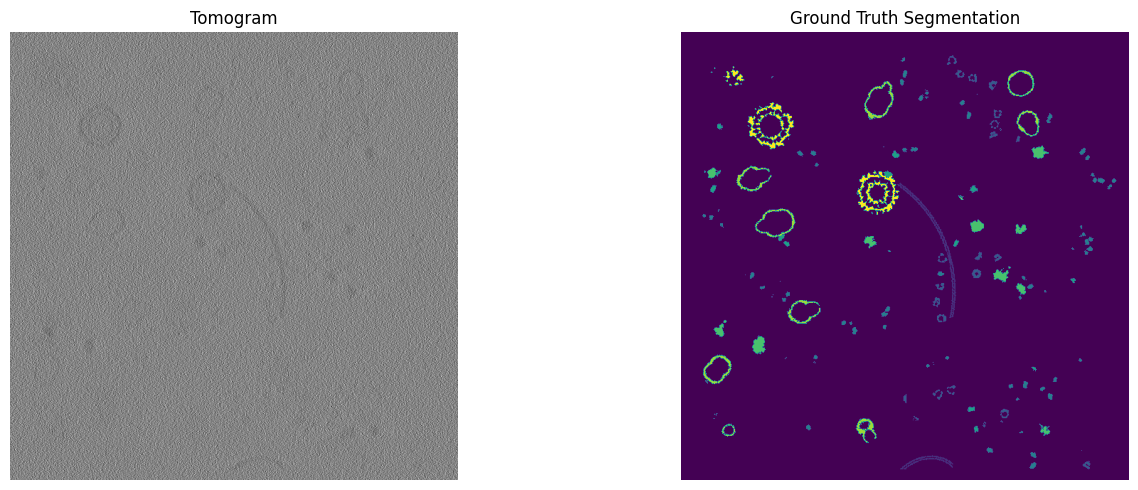

In [4]:
import matplotlib.pyplot as plt

# Plot the images
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.title('Tomogram')
plt.imshow(data_dicts[0]['image'][90],cmap='gray')
plt.axis('off')

# Original Image
plt.subplot(1, 2, 2)
plt.title('Ground Truth Segmentation')
plt.imshow(data_dicts[0]['label'][90])
plt.axis('off')

plt.tight_layout()
plt.show()

## Preparing Dataloaders

In [5]:
# Define transforms for image and segmentation
transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    ScaleIntensityRanged(keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    EnsureTyped(keys=["image", "label"]),
    Resized(keys=["image", "label"], spatial_size=(96, 96, 96)),  # Resize all images and labels to the same size
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=(1, 2)),
    RandZoomd(keys=["image", "label"], prob=0.2, min_zoom=0.9, max_zoom=1.1)
])

/hpc/mydata/kevin.zhao/miniconda3/envs/mlchallenge/lib/python3.9/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [6]:
val_split = max(int(0.2 * len(data_dicts)), 1)
train_files, val_files = data_dicts[val_split:], data_dicts[:val_split]

# Ensure non-empty datasets
if not train_files:
    raise ValueError("Training dataset is empty. Please provide non-empty data.")
if not val_files:
    raise ValueError("Validation dataset is empty. Please provide non-empty data.")
    
print(f"Number of training samples: {len(train_files)}")
print(f"Number of validation samples: {len(val_files)}")

train_ds = CacheDataset(data=train_files, transform=transforms)
val_ds = CacheDataset(data=val_files, transform=transforms)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4, pin_memory=torch.cuda.is_available())
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4, pin_memory=torch.cuda.is_available())

Number of training samples: 22
Number of validation samples: 5


Loading dataset: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


## Setup model

In [8]:
# Set up mlflow
mlflow.end_run()
mlflow.set_experiment('training UNET model')
mlflow.start_run()

<ActiveRun: >

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Create UNet, DiceLoss and Adam optimizer
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

loss_function = DiceLoss(sigmoid=True)
dice_metric = MeanDice(include_background=False)
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr)

cuda


In [10]:
def prepare_batch(batch, device=None, non_blocking=False):
    x = batch["image"]
    y = batch["label"]
    return (
        x.to(device=device, non_blocking=non_blocking),
        y.to(device=device, non_blocking=non_blocking),
    )

def supervised_update_function(engine, batch):
    model.train()
    optimizer.zero_grad()
    x, y = prepare_batch(batch, device, non_blocking=True)
    y_pred = model(x)
    loss = loss_function(y_pred, y)
    loss.backward()
    optimizer.step()
    print(f"Epoch[{engine.state.epoch}] Iteration[{engine.state.iteration}] Loss: {loss.item()}")
    return loss.item()  # Ensure the loss is returned as a float

## Setup trainer and tracking

In [11]:
import os
pwd = os.path.dirname(os.path.realpath("__file__"))
log_dir = os.path.join(pwd, "logs")

trainer = Engine(supervised_update_function)
checkpoint_handler = ModelCheckpoint(log_dir, "net", n_saved=10, require_empty=False)
trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpoint_handler, {"model": model, "optimizer": optimizer})

# StatsHandler prints loss at every iteration
# user can also customize print functions and can use output_transform to convert
# engine.state.output if it's not a loss value
train_stats_handler = StatsHandler(name="trainer", output_transform=lambda x: x)
train_stats_handler.attach(trainer)

# TensorBoardStatsHandler plots loss at every iteration
train_tensorboard_stats_handler = TensorBoardStatsHandler(log_dir=log_dir, output_transform=lambda x: x)
train_tensorboard_stats_handler.attach(trainer)

# MLFlowHandler plots loss at every iteration on MLFlow web UI
mlflow_dir = os.path.join(log_dir, "mlruns")
train_mlflow_handler = MLFlowHandler(tracking_uri=Path(mlflow_dir).as_uri(), output_transform=lambda x: x)
train_mlflow_handler.attach(trainer)



val_metrics = {"Mean_Dice": dice_metric}
post_pred = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
post_label = AsDiscrete(threshold=0.5)

evaluator = create_supervised_evaluator(
    model,
    metrics={"Loss": Loss(loss_function), "Mean_Dice": dice_metric},
    device=device,
    non_blocking=True,
    prepare_batch=prepare_batch,
)

tensorboard_image_handler = TensorBoardImageHandler(
    log_dir="./logs",
    batch_transform=lambda batch: (batch["image"], batch["label"]),
    output_transform=lambda output: output,
    global_iter_transform=lambda x: trainer.state.epoch
)
evaluator.add_event_handler(Events.EPOCH_COMPLETED, tensorboard_image_handler)


@trainer.on(Events.EPOCH_COMPLETED(every=1))
def run_validation(engine):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    mean_dice = metrics["Mean_Dice"]
    print(f"Validation Results - Epoch: {engine.state.epoch} Mean Dice: {mean_dice:.4f}")
    mlflow.log_metric("mean_dice", mean_dice, step=engine.state.epoch)


    
# Add stats event handler to print validation stats via evaluator
val_stats_handler = StatsHandler(
    name="evaluator",
    # no need to print loss value, so disable per iteration output
    output_transform=lambda x: None,
    # fetch global epoch number from trainer
    global_epoch_transform=lambda x: trainer.state.epoch,
)
val_stats_handler.attach(evaluator)

# add handler to record metrics to TensorBoard at every validation epoch
val_tensorboard_stats_handler = TensorBoardStatsHandler(
    log_dir=log_dir,
    # no need to plot loss value, so disable per iteration output
    output_transform=lambda x: None,
    # fetch global epoch number from trainer
    global_epoch_transform=lambda x: trainer.state.epoch,
)
val_tensorboard_stats_handler.attach(evaluator)

# add handler to record metrics to MLFlow at every validation epoch
val_mlflow_handler = MLFlowHandler(
    tracking_uri=Path(mlflow_dir).as_uri(),
    # no need to plot loss value, so disable per iteration output
    output_transform=lambda x: None,
    # fetch global epoch number from trainer
    global_epoch_transform=lambda x: trainer.state.epoch,
)
val_mlflow_handler.attach(evaluator)
      
    
num_epochs = 10
trainer.run(train_loader, max_epochs=num_epochs)

# Log model with mlflow
mlflow.pytorch.log_model(model, "model")
mlflow.end_run()

Epoch[1] Iteration[1] Loss: 0.8212122917175293
2024-09-06 01:19:19,927 - INFO - Epoch: 1/10, Iter: 1/22 -- Loss: 0.8212 
Epoch[1] Iteration[2] Loss: 0.8045812845230103
2024-09-06 01:19:19,954 - INFO - Epoch: 1/10, Iter: 2/22 -- Loss: 0.8046 
Epoch[1] Iteration[3] Loss: 0.8336309194564819
2024-09-06 01:19:19,979 - INFO - Epoch: 1/10, Iter: 3/22 -- Loss: 0.8336 
Epoch[1] Iteration[4] Loss: 0.8345491290092468
2024-09-06 01:19:20,009 - INFO - Epoch: 1/10, Iter: 4/22 -- Loss: 0.8345 
Epoch[1] Iteration[5] Loss: 0.813370943069458
2024-09-06 01:19:20,033 - INFO - Epoch: 1/10, Iter: 5/22 -- Loss: 0.8134 
Epoch[1] Iteration[6] Loss: 0.8195641040802002
2024-09-06 01:19:20,061 - INFO - Epoch: 1/10, Iter: 6/22 -- Loss: 0.8196 
Epoch[1] Iteration[7] Loss: 0.8523513078689575
2024-09-06 01:19:20,084 - INFO - Epoch: 1/10, Iter: 7/22 -- Loss: 0.8524 
Epoch[1] Iteration[8] Loss: 0.8189815282821655
2024-09-06 01:19:20,108 - INFO - Epoch: 1/10, Iter: 8/22 -- Loss: 0.8190 
Epoch[1] Iteration[9] Loss: 0.766

2024/09/06 01:19:37 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.4.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/09/06 01:19:51 WARNING mlflow.utils.requirements_utils: Found torchaudio version (2.4.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchaudio==2.4.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/09/06 01:19:51 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.19.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.19.0' without the local ver